# Figure 1 Surface soil categorisation according to the pH across the regions of Abu Dhabi, Al Ain and Al Dhafra

Sites (dedup by SiteUID): 84


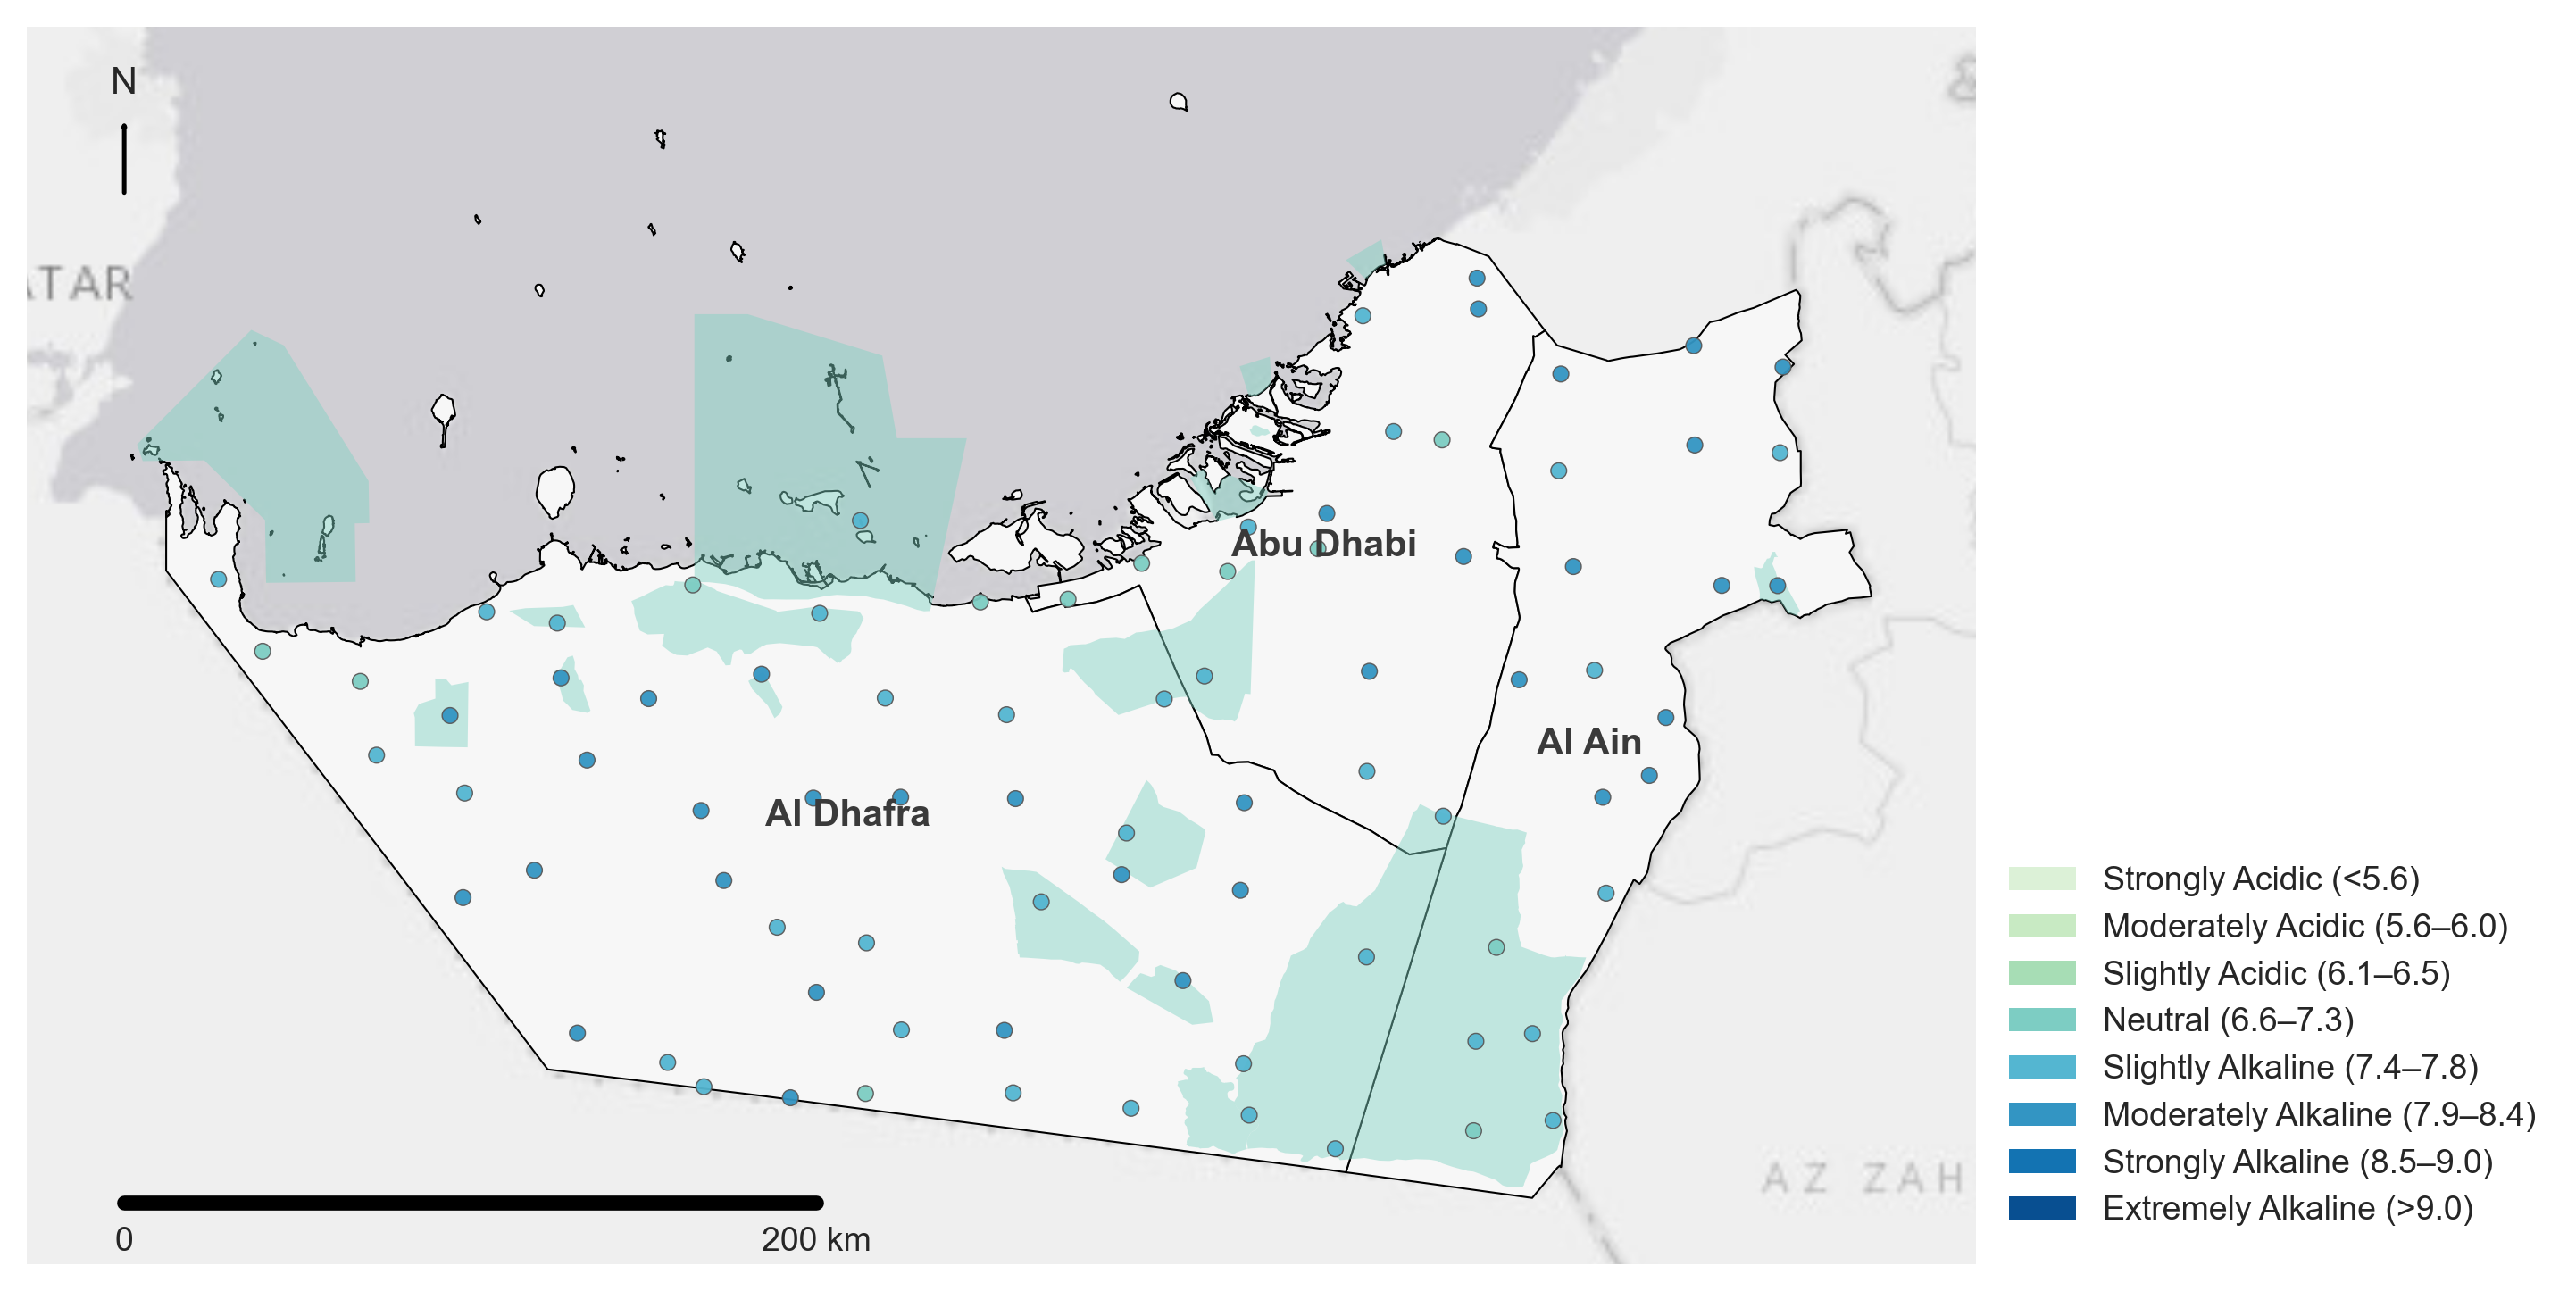

In [9]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx
import matplotlib as mpl

import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle, FancyArrowPatch, Patch

mpl.rcParams["figure.dpi"] = 300
mpl.rcParams["savefig.dpi"] = 300

# =================================================
# 0) Config
# =================================================
EXCEL_PATH = r"../Soil quality data/Soil quality data 2025.xlsx"
SHEET_NAME = "PHChemical"

PROTECTED_GPKG = "../data_hmq/Map/abu_dhabi_protected_areas.gpkg"
PROTECTED_LAYER = "Protected_Areas"

ABU_DHABI_SHP = r"../data_hmq/Map/abu_dhabi.shp"
BASEMAP = cx.providers.Esri.WorldGrayCanvas

OUT_DIR = r"../Result_hmq/Ch10_Figures"
os.makedirs(OUT_DIR, exist_ok=True)

# 你希望的 3 个区（匹配用关键词）
REGION_KEYWORDS = [
    ("Al Dhafra", ["Dhafra"]),
    ("Abu Dhabi", ["Abu Dhabi"]),
    ("Al Ain",    ["Ain"]),
]

# AOI bbox padding（米）
PAD_MIN_M = 1000
PAD_RATIO = 0.05

# pH bins（low < x <= high）
ph_bins = [
    (-float("inf"), 5.6,  "Strongly Acidic (<5.6)"),
    (5.6, 6.0,       "Moderately Acidic (5.6–6.0)"),
    (6.1, 6.5,       "Slightly Acidic (6.1–6.5)"),
    (6.6, 7.3,       "Neutral (6.6–7.3)"),
    (7.4, 7.8,       "Slightly Alkaline (7.4–7.8)"),
    (7.9, 8.4,       "Moderately Alkaline (7.9–8.4)"),
    (8.5, 9.0,       "Strongly Alkaline (8.5–9.0)"),
    (9.0, float("inf"), "Extremely Alkaline (>9.0)"),
]

# 从 cmap 抽离散颜色（你可以改成 "cividis" / "viridis" / "YlOrBr" / "plasma" 等）
CMAP_NAME = "GnBu"

# =================================================
# 1) Decorations: North arrow + scale bar
# =================================================
def add_north_arrow(ax, x=0.05, y=0.86, dy=0.07):
    arrow = FancyArrowPatch(
        (x, y), (x, y + dy),
        transform=ax.transAxes,
        arrowstyle="-|>",
        linewidth=1.2,
        color="black",
        zorder=30
    )
    ax.add_patch(arrow)
    ax.text(
        x, y + dy + 0.01, "N",
        transform=ax.transAxes,
        ha="center", va="bottom",
        fontsize=10, zorder=30
    )

def add_scale_bar(ax, xmin, ymin, xmax, ymax, length_km=200):
    length_m = length_km * 1000
    x0 = xmin + 0.05 * (xmax - xmin)
    y0 = ymin + 0.05 * (ymax - ymin)

    ax.plot([x0, x0 + length_m], [y0, y0],
            color="black", linewidth=4, zorder=30)

    ax.text(x0, y0 - 0.02 * (ymax - ymin), "0",
            ha="center", va="top", fontsize=9)

    ax.text(x0 + length_m, y0 - 0.02 * (ymax - ymin),
            f"{length_km} km",
            ha="center", va="top",
            fontsize=9)

# =================================================
# 2) Read base data
# =================================================
data = pd.read_excel(EXCEL_PATH, sheet_name=SHEET_NAME)
data = data[(data["PHUID"] == 1) & (data["PHSampleUID"] == 1) & (data["SurveyID"] == 11)]
regions = gpd.read_file(ABU_DHABI_SHP).to_crs(3857)

protected = gpd.read_file(PROTECTED_GPKG, layer=PROTECTED_LAYER).to_crs(3857)
protected = protected[(~protected.geometry.isna()) & (~protected.geometry.is_empty)].copy()

# =================================================
# 3) Find region name field
# =================================================
candidate_fields = ["NAMEENGLISH", "NameEnglish", "NAME", "Name", "Region", "REGION", "emirate", "EMIRATE"]
name_field = None
for f in candidate_fields:
    if f in regions.columns:
        name_field = f
        break
if name_field is None:
    raise ValueError(f"Cannot find region name field in regions. Available columns: {list(regions.columns)}")

# =================================================
# 4) Build points GeoDataFrame (dedup by SiteUID) + satph
#    NOTE: this uses ALL SurveyID. If you want one land-use, filter by SurveyID here.
# =================================================
sub = data.copy()
sub = sub.dropna(subset=["Longitude", "Latitude", "SiteUID", "satph"])
sub = sub.sort_values("SiteUID").drop_duplicates(subset=["SiteUID"])

gdf = gpd.GeoDataFrame(
    sub,
    geometry=gpd.points_from_xy(sub["Longitude"], sub["Latitude"]),
    crs="EPSG:4326",
).to_crs(3857)

print("Sites (dedup by SiteUID):", len(gdf))

# =================================================
# 5) pH binning + colors sampled from cmap
# =================================================
labels = [b[2] for b in ph_bins]

# round to 1 decimal to avoid gaps like 6.0 vs 6.1
gdf["satph_round"] = pd.to_numeric(gdf["satph"], errors="coerce").round(1)

def _assign_ph_label(x):
    if pd.isna(x):
        return np.nan
    for lo, hi, lab in ph_bins:
        if (x >= lo) and (x <= hi):
            return lab
    return np.nan

gdf["ph_label"] = gdf["satph_round"].apply(_assign_ph_label)

# sample discrete colors from cmap (avoid too-light ends)
cmap = mpl.colormaps.get(CMAP_NAME)
n = len(labels)
sample_pos = np.linspace(0.15, 0.95, n)
ph_colors = [mcolors.to_hex(cmap(p)) for p in sample_pos]
label2color = dict(zip(labels, ph_colors))

# color per point (NaN -> grey)
gdf["ph_color"] = gdf["ph_label"].map(label2color).fillna("#9e9e9e")

# legend handles
ph_legend_handles = [
    Patch(facecolor=label2color[lab], edgecolor="none", label=lab)
    for lab in labels
]

# =================================================
# 6) Split regions (3 main regions)
# =================================================
regions_3 = []
for label, keys in REGION_KEYWORDS:
    mask = np.zeros(len(regions), dtype=bool)
    for k in keys:
        mask |= regions[name_field].astype(str).str.contains(k, case=False, na=False)
    reg = regions[mask].copy()
    if len(reg) == 0:
        print(f"[WARN] Region '{label}' not matched by keywords {keys} in field '{name_field}'")
    else:
        # dissolve to one polygon per label, then compute a safe interior point
        reg_one = reg.dissolve()  # index becomes 0/label-like; geometry is merged
        rp = reg_one.geometry.iloc[0].representative_point()  # guaranteed inside polygon
        regions_3.append((label, rp.x, rp.y))

# =================================================
# 7) FULL MAP (points colored by pH bins + protected areas)
# =================================================
fig, ax = plt.subplots(figsize=(12, 6))

xmin, ymin, xmax, ymax = regions.total_bounds
xpad = 0.06 * (xmax - xmin)
ypad = 0.06 * (ymax - ymin)

ax.set_xlim(xmin - xpad, xmax + xpad)
ax.set_ylim(ymin - ypad, ymax + ypad)

cx.add_basemap(ax, source=BASEMAP, zoom=7, attribution=False)

regions.plot(ax=ax, facecolor="#f7f7f7", edgecolor="black", linewidth=0.5, zorder=5)

protected.plot(
        ax=ax,
        facecolor="#7FD3C3",
        edgecolor="none",
        alpha=0.45,
        zorder=6
    )

ax.scatter(
    gdf.geometry.x, gdf.geometry.y,
    s=18, c=gdf["ph_color"],
    edgecolors="#5a5a5a",
    linewidths=0.35,
    alpha=0.95,
    zorder=10
)

# --- region labels at polygon "middle" (interior point) ---
for label, x, y in regions_3:
    ax.text(
        x, y, label,
        ha="center", va="center",
        fontsize=10, weight="bold", color="#3a3a3a", zorder=21
    )

# Legend (pH bins)
ax.legend(
    handles=ph_legend_handles,
    loc="lower left",
    bbox_to_anchor=(1.01, 0.02),  # 👉 图外右侧，靠下
    frameon=False,
    fontsize=9,
    ncol=1,
    borderaxespad=0.0
)

ax.set_axis_off()
add_north_arrow(ax)
add_scale_bar(ax, xmin - xpad, ymin - ypad, xmax + xpad, ymax + ypad, length_km=200)

plt.show()
fig.savefig(os.path.join(OUT_DIR, "Ch10_pH_full.png"), bbox_inches="tight", pad_inches=0.1)
fig.savefig(os.path.join(OUT_DIR, "Ch10_pH_full.svg"), bbox_inches="tight", pad_inches=0.1)


Sites (dedup by SiteUID): 84


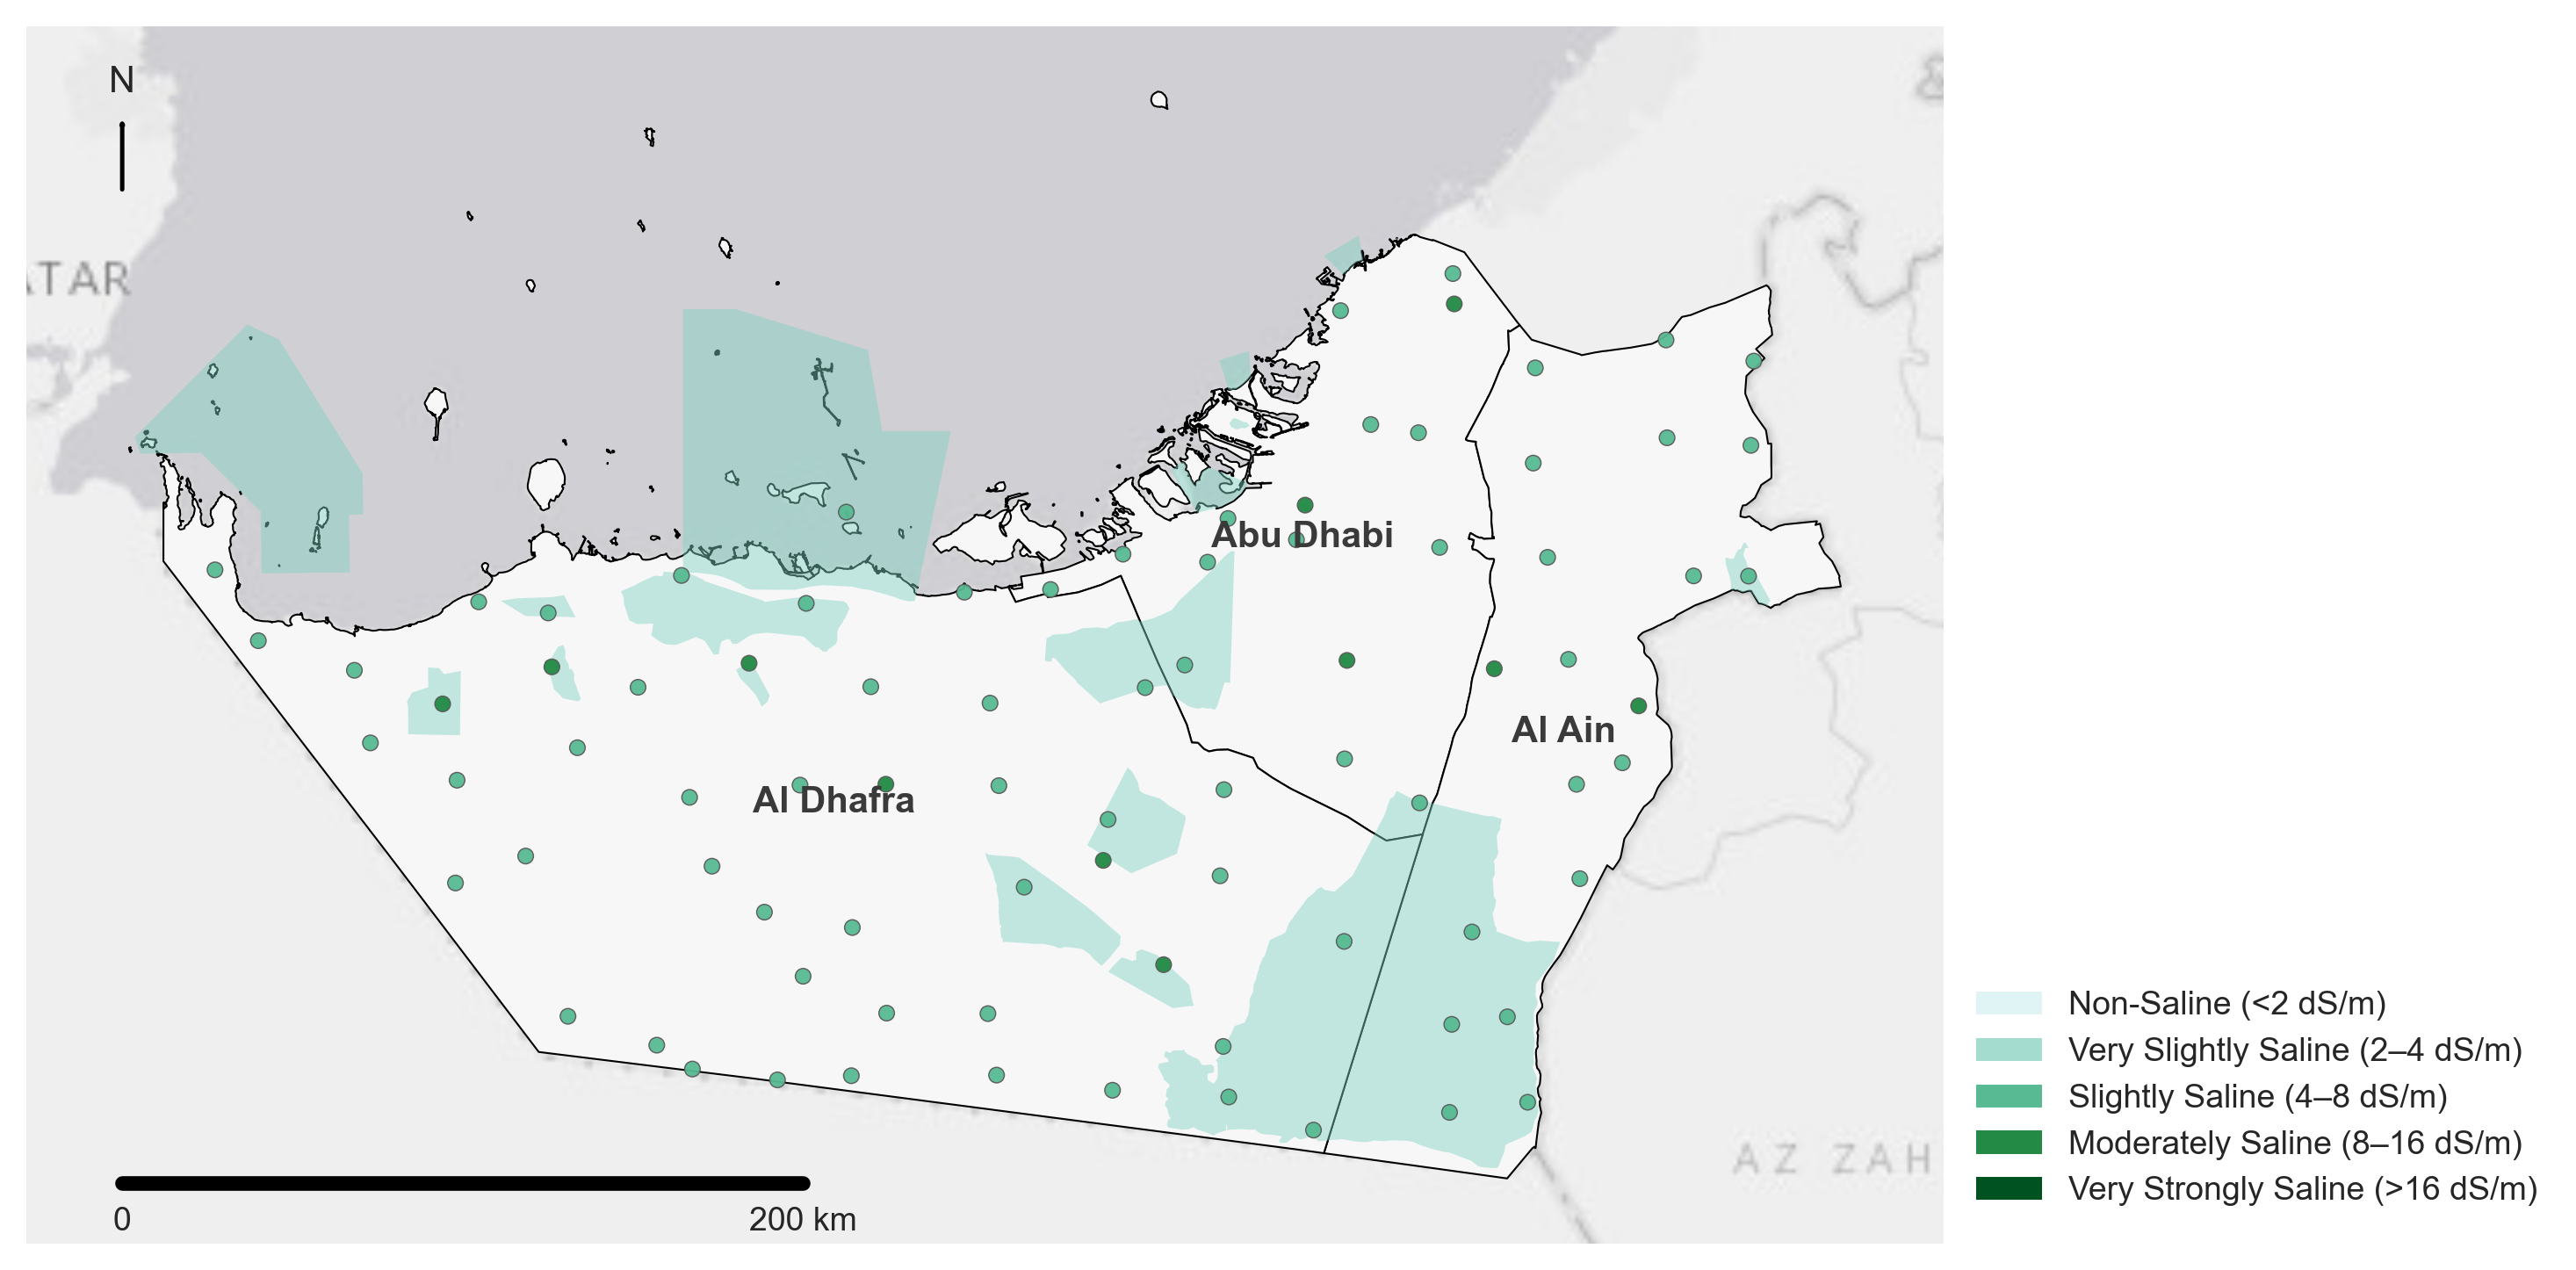

In [10]:
# pH bins（low < x <= high）
ph_bins = [
    (-float("inf"), 2.0,    "Non-Saline (<2 dS/m)"),
    (2.0, 4.0,             "Very Slightly Saline (2–4 dS/m)"),
    (4.0, 8.0,             "Slightly Saline (4–8 dS/m)"),
    (8.0, 16.0,            "Moderately Saline (8–16 dS/m)"),
    (16.0, float("inf"),   "Very Strongly Saline (>16 dS/m)"),
]

# 从 cmap 抽离散颜色（你可以改成 "cividis" / "viridis" / "YlOrBr" / "plasma" 等）
CMAP_NAME = "BuGn"

# =================================================
# 2) Read base data
# =================================================
data = pd.read_excel(EXCEL_PATH, sheet_name=SHEET_NAME)
data = data[(data["PHUID"] == 1) & (data["PHSampleUID"] == 1) & (data["SurveyID"] == 11)]
regions = gpd.read_file(ABU_DHABI_SHP).to_crs(3857)

protected = gpd.read_file(PROTECTED_GPKG, layer=PROTECTED_LAYER).to_crs(3857)
protected = protected[(~protected.geometry.isna()) & (~protected.geometry.is_empty)].copy()

# =================================================
# 3) Find region name field
# =================================================
candidate_fields = ["NAMEENGLISH", "NameEnglish", "NAME", "Name", "Region", "REGION", "emirate", "EMIRATE"]
name_field = None
for f in candidate_fields:
    if f in regions.columns:
        name_field = f
        break
if name_field is None:
    raise ValueError(f"Cannot find region name field in regions. Available columns: {list(regions.columns)}")

# =================================================
# 4) Build points GeoDataFrame (dedup by SiteUID) + satph
#    NOTE: this uses ALL SurveyID. If you want one land-use, filter by SurveyID here.
# =================================================
sub = data.copy()
sub = sub.dropna(subset=["Longitude", "Latitude", "SiteUID", "satph"])
sub = sub.sort_values("SiteUID").drop_duplicates(subset=["SiteUID"])

gdf = gpd.GeoDataFrame(
    sub,
    geometry=gpd.points_from_xy(sub["Longitude"], sub["Latitude"]),
    crs="EPSG:4326",
).to_crs(3857)

print("Sites (dedup by SiteUID):", len(gdf))

# =================================================
# 5) pH binning + colors sampled from cmap
# =================================================
labels = [b[2] for b in ph_bins]

# round to 1 decimal to avoid gaps like 6.0 vs 6.1
gdf["satph_round"] = pd.to_numeric(gdf["satph"], errors="coerce").round(1)

def _assign_ph_label(x):
    if pd.isna(x):
        return np.nan
    for lo, hi, lab in ph_bins:
        if (x > lo) and (x <= hi):
            return lab
    return np.nan

gdf["ph_label"] = gdf["satph_round"].apply(_assign_ph_label)

# sample discrete colors from cmap (avoid too-light ends)
cmap = mpl.colormaps.get(CMAP_NAME)
n = len(labels)
sample_pos = np.linspace(0.15, 0.95, n)
ph_colors = [mcolors.to_hex(cmap(p)) for p in sample_pos]
label2color = dict(zip(labels, ph_colors))

# color per point (NaN -> grey)
gdf["ph_color"] = gdf["ph_label"].map(label2color).fillna("#9e9e9e")

# legend handles
ph_legend_handles = [
    Patch(facecolor=label2color[lab], edgecolor="none", label=lab)
    for lab in labels
]

# =================================================
# 6) Split regions (3 main regions)
# =================================================
regions_3 = []
for label, keys in REGION_KEYWORDS:
    mask = np.zeros(len(regions), dtype=bool)
    for k in keys:
        mask |= regions[name_field].astype(str).str.contains(k, case=False, na=False)
    reg = regions[mask].copy()
    if len(reg) == 0:
        print(f"[WARN] Region '{label}' not matched by keywords {keys} in field '{name_field}'")
    else:
        # dissolve to one polygon per label, then compute a safe interior point
        reg_one = reg.dissolve()  # index becomes 0/label-like; geometry is merged
        rp = reg_one.geometry.iloc[0].representative_point()  # guaranteed inside polygon
        regions_3.append((label, rp.x, rp.y))

# =================================================
# 7) FULL MAP (points colored by pH bins + protected areas)
# =================================================
fig, ax = plt.subplots(figsize=(12, 6))

xmin, ymin, xmax, ymax = regions.total_bounds
xpad = 0.06 * (xmax - xmin)
ypad = 0.06 * (ymax - ymin)

ax.set_xlim(xmin - xpad, xmax + xpad)
ax.set_ylim(ymin - ypad, ymax + ypad)

cx.add_basemap(ax, source=BASEMAP, zoom=7, attribution=False)

regions.plot(ax=ax, facecolor="#f7f7f7", edgecolor="black", linewidth=0.5, zorder=5)

protected.plot(
        ax=ax,
        facecolor="#7FD3C3",
        edgecolor="none",
        alpha=0.45,
        zorder=6
    )

ax.scatter(
    gdf.geometry.x, gdf.geometry.y,
    s=18, c=gdf["ph_color"],
    edgecolors="#5a5a5a",
    linewidths=0.35,
    alpha=0.95,
    zorder=10
)

# --- region labels at polygon "middle" (interior point) ---
for label, x, y in regions_3:
    ax.text(
        x, y, label,
        ha="center", va="center",
        fontsize=10, weight="bold", color="#3a3a3a", zorder=21
    )

# Legend (pH bins)
ax.legend(
    handles=ph_legend_handles,
    loc="lower left",
    bbox_to_anchor=(1.01, 0.02),  # 👉 图外右侧，靠下
    frameon=False,
    fontsize=9,
    ncol=1,
    borderaxespad=0.0
)

ax.set_axis_off()
add_north_arrow(ax)
add_scale_bar(ax, xmin - xpad, ymin - ypad, xmax + xpad, ymax + ypad, length_km=200)

plt.show()
fig.savefig(os.path.join(OUT_DIR, "Ch10_ECe_full.png"), bbox_inches="tight", pad_inches=0.1)
fig.savefig(os.path.join(OUT_DIR, "Ch10_ECe_full.svg"), bbox_inches="tight", pad_inches=0.1)
